### Step 1: Retrieve homologs of Gloeobacter rhodopsin (GR)

To identify homologs of **Gloeobacter rhodopsin (GR)**, I ran a BLASTp search against the UniRef90 database using the  
[`scripts/blast_uniref.py`](../scripts/blast_uniref.py) helper script.

- Query: `data/GR.fasta` (accession BAC88139.1)
- Database: UniRef90
- Program: BLASTp
- Date run: 2025-08-22
- Top hits retained: 150
- Output: `data/BAC88139.1_top150_uniref90.fasta`

This was executed once on 2025-08-22 to generate results for downstream analysis.  
To avoid hitting EBI servers repeatedly, the script call is documented below but not re-executed.

Later - removed 3 sequences from the file that were missing the first transmembrane domain (UPI0035935AE6, AOA2P8WHZ5, UPI001C63F925) because they're likely incomplete genes and wouldn't form a functional protein. 

In [1]:
from pathlib import Path
from datetime import datetime

#Run ID to be used for naming output files
RUN_ID = datetime.now().strftime("%Y%m%d")
RUNID_DASH = datetime.now().strftime("%Y-%m-%d")


#Define paths for current project
# --- Centralized paths ---
ROOT = Path("..")
DATA = ROOT / "data"
LOGS = ROOT / "logs"
SCRIPTS = ROOT / "scripts"
RESULTS = ROOT / "results"
ALIGN_DIR = RESULTS / "align"
TREE_DIR = RESULTS / "trees"
FIGURES = RESULTS / "figures"

# --- Key files ---
GR_FASTA = DATA / "GR.fasta" #Starting file for BLAST search 
BLAST_OUT = DATA / "BAC88139.1_top150_uniref90.fasta"
RENAMED_FASTA = DATA / "BAC88139.1_top150_uniref90.rename.fasta"

CULLED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}.fasta"
DISCARDED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.discarded_{RUN_ID}.fasta"
SUMMARY_CSV = LOGS / f"GR_max_similarity_{RUN_ID}.csv"

# --- Alignment and tree output ---
ALIGN_DIR.mkdir(parents=True, exist_ok=True)
TREE_DIR.mkdir(parents=True, exist_ok=True)
ALN_FASTA = ALIGN_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ALN.faa"
IQ_PREFIX = TREE_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ML_{RUNID_DASH}"


In [ ]:
# Command used to generate results on 2025-08-22:
# (not executed here to avoid re-running BLAST queries against EBI servers)
# !python {SCRIPTS / "blast_uniref.py"} {GR_FASTA} oakley@ucsb.edu --max_hits 150 --out {BLAST_OUT} --log {LOGS / "blast_runs.log"}

In [4]:
# Load the saved BLAST results
from Bio import SeqIO

print(f"Loading: {BLAST_OUT}")

records = list(SeqIO.parse(BLAST_OUT, "fasta"))
print(f"Loaded {len(records)} sequences")

# Preview a few IDs
for record in records[:5]:
    print(record.id)


Loading: ../data/BAC88139.1_top150_uniref90.fasta
Loaded 144 sequences
UniRef90_Q7NP59
UniRef90_A0A969T0G4
UniRef90_A0A2W7ARY7
UniRef90_A0A969FEC7
UniRef90_A0A925M2S9


In [ ]:
# Rename the sequences with a common prefix to keep track of them during analyses

!python {SCRIPTS / "rename_fasta_headers.py"} \
    {BLAST_OUT} \
    {RENAMED_FASTA} \
    --prefix CYANO150 

Reformatted 144 headers → ../data/BAC88139.1_top150_uniref90.rename.fasta
[cleaning] dropped_meta_lines=1, salvaged_seq_fragments=0, filtered_chars=0


In [7]:
# Cull similar sequences to reduce redundancy. Target is 90 total sequences.
#To reduce redundancy, I removed highly similar sequences based on pairwise similarity
#(using Biopython’s `PairwiseAligner`, global mode). I keep a per-sequence
#“max similarity to any other” summary in `logs/` for provenance.

!python {SCRIPTS / "cull_similar_seqs.py"} \
  {RENAMED_FASTA} \
  {CULLED_FASTA} \
  --discarded-fasta {DISCARDED_FASTA} \
  --discard 54 \
  --method align --align-mode global --match 1 --mismatch 0 --gap-open -1 --gap-extend -0.5 \
  --summary-csv {SUMMARY_CSV}

Loaded 144 sequences from ../data/BAC88139.1_top150_uniref90.rename.fasta
Progress: 0/144 sequences processed...
Progress: 14/144 sequences processed...
Progress: 28/144 sequences processed...
Progress: 42/144 sequences processed...
Progress: 56/144 sequences processed...
Progress: 70/144 sequences processed...
Progress: 84/144 sequences processed...
Progress: 98/144 sequences processed...
Progress: 112/144 sequences processed...
Progress: 126/144 sequences processed...
Progress: 140/144 sequences processed...
Retained 90 sequences → ../data/BAC88139.1_top150_uniref90.rename.culled_20250827.fasta
Discarded 54 sequences → ../data/BAC88139.1_top150_uniref90.rename.discarded_20250827.fasta


In [10]:
# Next build a quick tree as a sanity check on the sequences.
# This uses MAFFT for alignment and IQ-TREE2 for tree building.
# MAFFT auto strategy; uses all cores available (-1). 

!mafft --auto --thread -1 --quiet "{CULLED_FASTA}" > "{ALN_FASTA}"
print("Aligned ->", ALN_FASTA)

# Build a maximum likelihood tree with IQ-TREE2, using the LG+F+R4 model.
# This takes about 3 minutes with 90 sequences.
!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet



Aligned -> ../results/align/BAC88139.1_top150_uniref90.rename.culled_20250827_ALN.faa
Checkpoint (../results/trees/BAC88139.1_top150_uniref90.rename.culled_20250827_ML_2025-08-27.ckp.gz) indicates that a previous run successfully finished
Use `-redo` option if you really want to redo the analysis and overwrite all output files.
Use `--redo-tree` option if you want to restore ModelFinder and only redo tree search.
Use `--undo` option if you want to continue previous run when changing/adding options.


Saved tree figure to: ../results/figures/BAC88139.1_top150_uniref90.rename.culled_20250827_ML_2025-08-27_tree.pdf


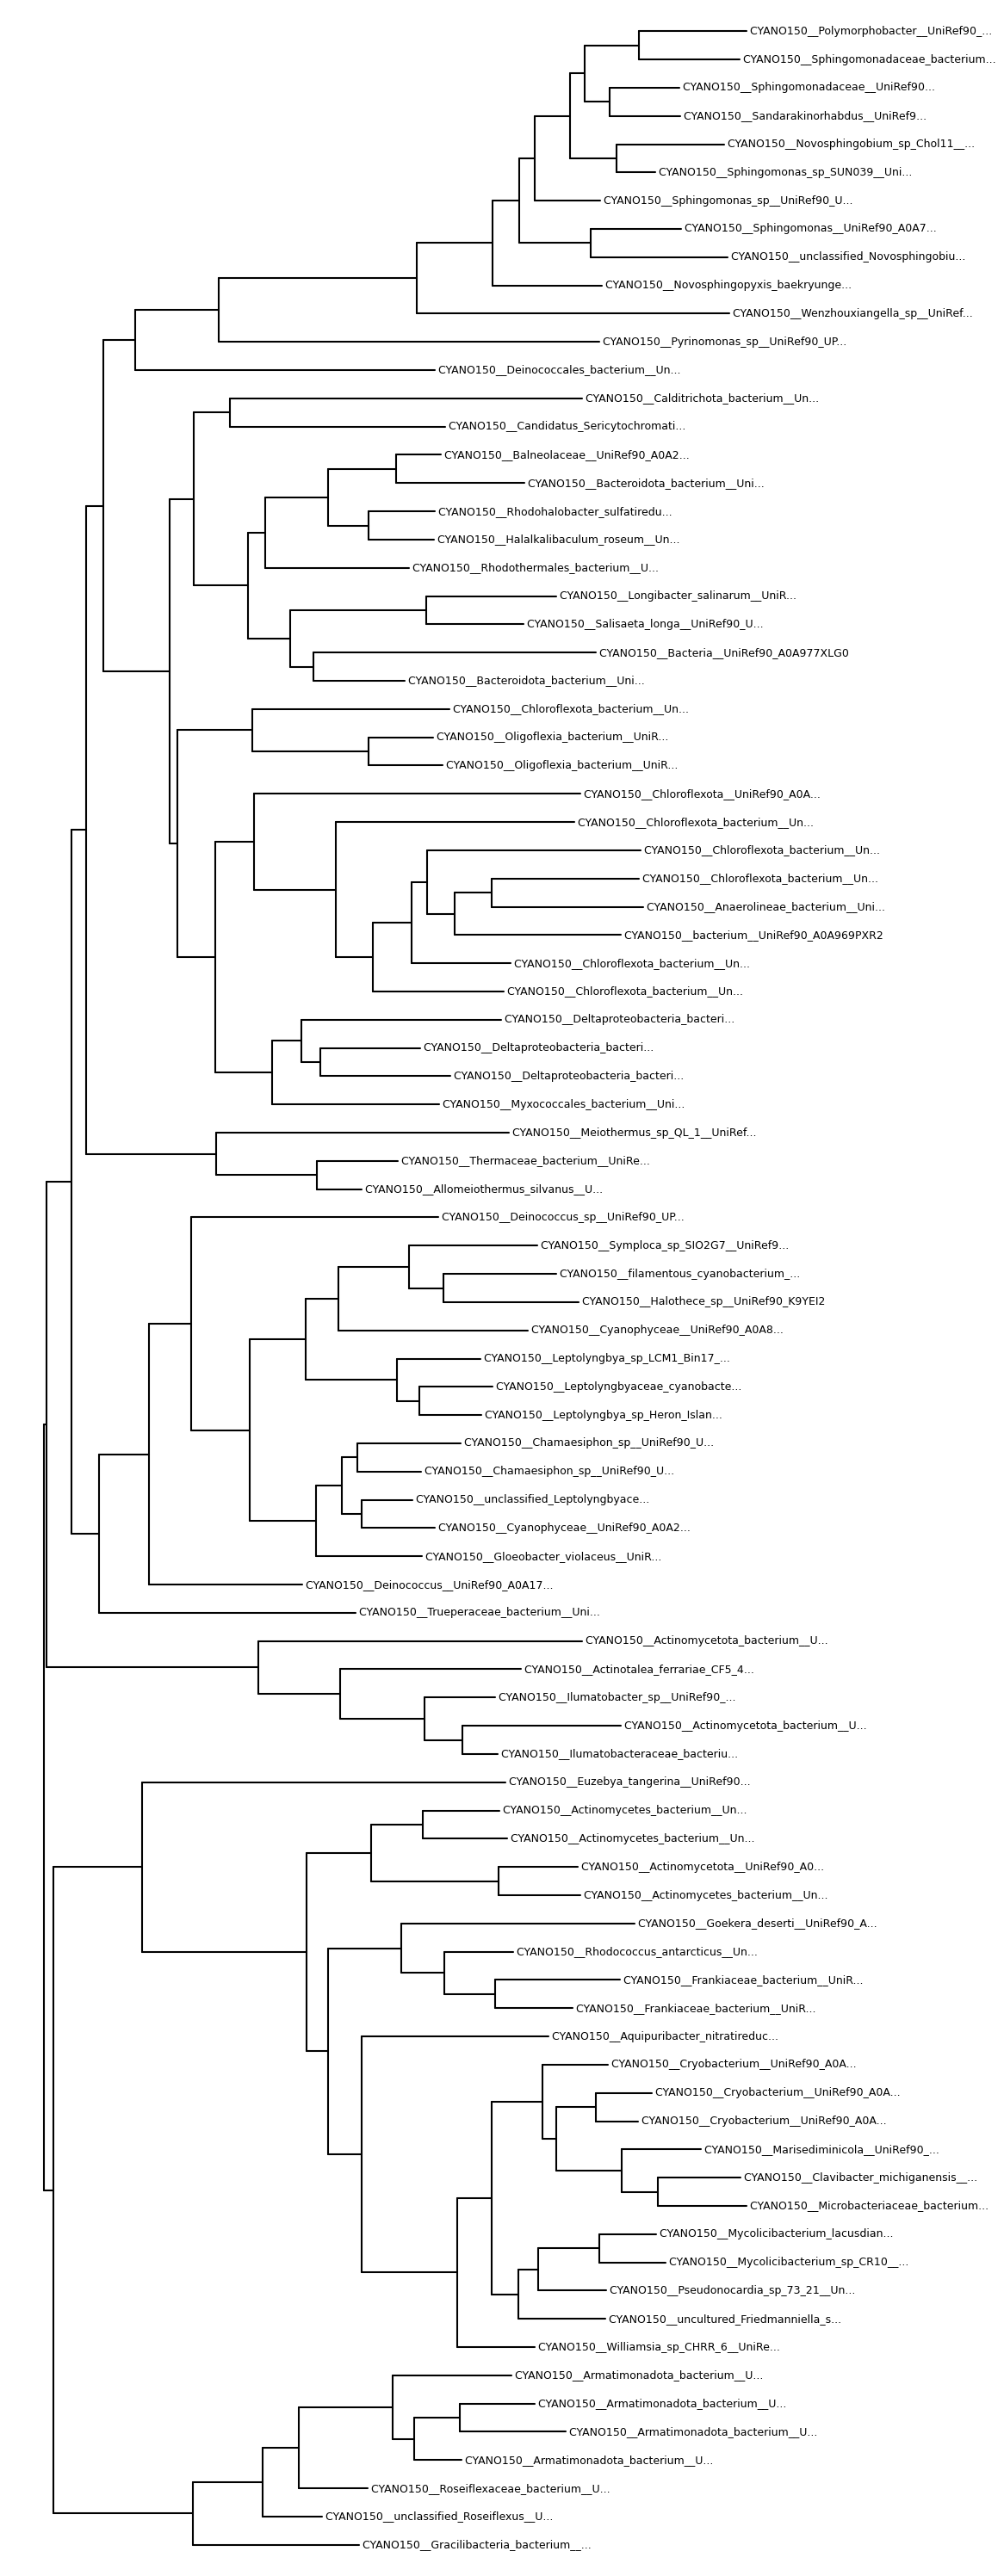

In [3]:
import sys
sys.path.append(str(SCRIPTS))
from plot_tree import plot_tree

# Use IQ_PREFIX for the correct tree file path
tree_file = IQ_PREFIX.parent / (IQ_PREFIX.name + ".treefile")
fig_path = FIGURES / f"{IQ_PREFIX.name}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 30))


### Step 2: Identify a diversity of microbial rhodopsins by BLAST similarity to UniRef50

To expand the diversity of microbial rhodopsins, I performed DIAMOND BLASTp searches against a local copy of UniRef50 on the `knot` server at CNSI at UCSB. 
This step was done outside this repository due to the size of UniRef50 and compute requirements.


#### **Original bait FASTA files used for BLAST searches**

The following FASTA files were used as queries ("baits") for DIAMOND BLASTp searches against UniRef50.  
Each file contains a representative opsin gene from a diverse set of microbial lineages:

| Filename         | Accession         | Species/Strain                              | Description                        |
|------------------|-------------------|---------------------------------------------|------------------------------------|
| **BR_Halobacterium.fasta** | CAP14056.1        | Halobacterium salinarum R1                  | bacteriorhodopsin                  |
| **CyHR_Mastigocladopsis.fasta** | WP_017314391.1    | Mastigocladopsis repens                      | bacteriorhodopsin                  |
| **CyHR_Synechocystis.fasta** | WP_009632765.1    | Synechocystis sp. PCC 7509                   | bacteriorhodopsin                  |
| **CyR_Phormidesmis.fasta** | WP_074382570.1    | Phormidesmis priestleyi                      | bacteriorhodopsin                  |
| **CyR_Tolypothrix.fasta** | GAX43141.1        | Tolypothrix sp. NIES-4075                    | rhodopsin                          |
| **CyR_Calothrix.fasta** | BAY09002.1         | Calothrix sp. NIES-2098                      | rhodopsin                          |
| **EUK_Mixia_G7DX39.fasta** | G7DX39             | Mixia osmundae (strain CBS 9802 / IAM 14324 / JCM 22182 / KY 12970) | Opsin-1                            |
| **PR_proteobacterium.fasta** | AAG10475.1        | uncultured marine gamma proteobacterium EBAC31A08 | proteorhodopsin               |
| **XeR_Nostoc.fasta** | BAB74864.1         | Nostoc sp. PCC 7120 (= FACHB-418)            | bacteriorhodopsin                  |
| **XLR_Gloeobacter.fasta** | BAC88139.1         | Gloeobacter violaceus PCC 7421               | gll0198 (xanthorhodopsin-like)     |

Each of these FASTA files was used as a query in the BLAST workflow described above.  
The accession numbers and species names are included in the FASTA headers for traceability.

#### **Workflow on `knot` (single bait):**
```bash
#!/bin/bash

conda activate bioinf

diamond blastp -d /home/emily.lau/manuscripts/brittlestar/uniref_databases/uniref50.fasta -q cyr.fasta -o cyr_ref50_blast -f 6 -k 50
awk '{print $2}' cyr_ref50_blast | sort | uniq > cyr_ref50.txt
seqkit grep -nrf cyr_ref50.txt /home/oakley/projects/uniref_dbs/uniref50.fasta > cyr_50.fa
python modify_fa.py -i cyr_50.fa -o cyr_50b.fa -p Cyr
```

#### **Workflow on `knot` (multiple baits, SLURM array):**
```bash
#!/bin/bash
#SBATCH --job-name=process_opsin_fastas
#SBATCH --output=output_%A_%a.out
#SBATCH --error=error_%A_%a.err
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --array=0-5

source ~/.bashrc
conda activate bioinf

codes=("cyr" "cyhr" "xer" "pr" "xlr" "br")
code=${codes[$SLURM_ARRAY_TASK_ID]}
prefix=$(echo "$code" | awk '{print toupper(substr($0,1,1)) tolower(substr($0,2))}')

diamond blastp -d /home/emily.lau/manuscripts/brittlestar/uniref_databases/uniref50 -q "${code}.fasta" -o "${code}_ref50_blast" -f 6 -k 50
awk '{print $2}' "${code}_ref50_blast" | sort | uniq > "${code}_ref50.txt"
seqkit grep -nrf "${code}_ref50.txt" /home/oakley/projects/uniref_dbs/uniref50.fasta > "${code}_50.fa"
python modify_fa.py -i "${code}_50.fa" -o "${code}_50b.fa" -p "$prefix"
```

- Each bait (`cyr`, `cyhr`, `xer`, `pr`, `xlr`, `br`) is processed in parallel using a SLURM job array.
- The script standardizes FASTA headers with a prefix for each bait.

If needed, `modify_fa.py` was also copied to `scripts/` for reproducibility.

#### **Final step: Concatenate all FASTA files**

After processing each bait, I concatenated all the query and result FASTA files into a single file for downstream analysis:

```bash
# Concatenate the original bait and all processed UniRef hits
cat cyr.fasta cyhr.fasta br.fasta xer.fasta pr.fasta xlr.fasta *50b.fa *90b.fa > All_uniref_hits.fa
```

- This combines all bait sequences and their UniRef50/90 BLAST hits into `All_uniref_hits.fa`.
- The resulting file was transferred to this repository and placed in `data/` for further analysis.
- Sequences each have a prefix to identify which blast bait was used to find them